# KEGG vs BEL gene sets comparison

### This notebook calculates the Jaccard index for gene sets in the KEGG PATHWAY database and gene sets in BEL graphs for each pathway in the KEGG PATHWAY database

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from pybel import from_pickle

from pathme.constants import KEGG_BEL
from pathme.utils import get_files_in_folder, get_kegg_genes_from_pickles, get_genes_in_graph, jaccard_similarity

from bio2bel_kegg.manager import Manager

In [2]:
# Initiate KEGG Manager
kegg_manager = Manager()

### Get gene sets for each KEGG pathway in the KEGG PATHWAY database.

In [3]:
kegg_genes_set = kegg_manager.export_gene_sets()

### Get gene sets for each KEGG pathway BEL graph

In [4]:
# Get list of BEL graph pickles
pickles = get_files_in_folder(KEGG_BEL)

In [5]:
bel_genes_set = get_kegg_genes_from_pickles(KEGG_BEL, pickles, kegg_manager)

### For each pathway in the KEGG PATHWAY database, calculate the Jaccard index for gene sets from the database and from BEL graphs 

In [6]:
jaccard_similarities = jaccard_similarity(kegg_genes_set, bel_genes_set)

### Visualize Jaccard index distribution

/home/sarah/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


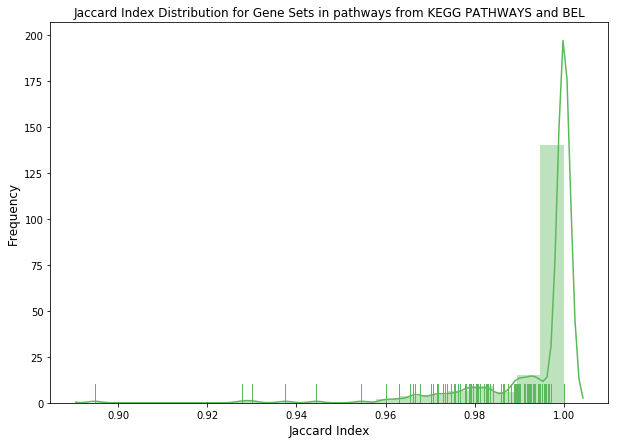

In [9]:
plt.figure(figsize=(10,7))
plt.title('Jaccard Index Distribution for Gene Sets in pathways from KEGG PATHWAYS and BEL', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Jaccard Index', fontsize=12)

sns.distplot(jaccard_similarities, axlabel='Jaccard Index', rug=True, bins=20, color='#5cb85c')


For all pathways in KEGG PATHWAYS, we plot the distribution of Jaccard indices as a measure of similarity between gene sets from the database and gene sets in the subsequently parsed BEL graphs.
 
A near perfect mapping of gene sets from KEGG PATHWAYS to BEL can be seen in the distribution; almost all gene sets in KEGG PATHWAYS are successfully parsed and converted into BEL entities. 